# Temporal & Thematic Forecasting

Analyze how topics and severity of global regulatory policies evolve over time using time series models.

### Import / Load Libraries

In [1]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
import matplotlib.pyplot as plt

In [2]:
# Load the cleaned file
df = pd.read_csv("../data/processed/cleaned_with_severity_zeroshot_20250719T043204Z.csv", parse_dates=["date"])

# Inspect top few rows
print(df.head())

  source                                              title  \
0   EDPB  The Italian SA imposes fines of 420 000 EUR on...   
1   EDPB  Biometrics for attendance recording. The Itali...   
2   EDPB  Swedish SA: Administrative fine against the Eq...   
3   EDPB  Targeted modifications of the GDPR: EDPB & EDP...   
4   EDPB  Irish Supervisory Authority fines TikTok €530 ...   

                                                link       date severity  
0  https://edpb.europa.eu/news/national-news/2025... 2025-07-15     HIGH  
1  https://edpb.europa.eu/news/national-news/2025... 2025-07-15   MEDIUM  
2  https://edpb.europa.eu/news/national-news/2025... 2025-07-15   MEDIUM  
3  https://edpb.europa.eu/news/news/2025/targeted... 2025-07-09   MEDIUM  
4  https://edpb.europa.eu/news/news/2025/irish-su... 2025-07-04     HIGH  


In [3]:
df.columns

Index(['source', 'title', 'link', 'date', 'severity'], dtype='object')

## Add Topics via Zero-Shot Classifier

We’re using a zero-shot classifier to assign a policy document (based on its title) to one best-fitting topic from the candidate list.

In [4]:
# Step 1: Define Candidate Topics
candidate_topics = [
    "Cross-border transfers",
    "Children’s data protection",
    "AI & automated decision-making",
    "Biometric data",
    "Fines & penalties",
    "Consent & transparency",
    "Surveillance & tracking",
    "International cooperation",
    "Data breach & incident response",
    "GDPR enforcement"
]


In [5]:
# Step 2: Run Zero-Shot Topic Classification

# Create classifier
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    framework="pt"  # Explicitly use PyTorch
)

# Predict topics using titles
predicted_topics = []
for title in tqdm(df["title"], desc="Classifying topics"):
    result = classifier(title, candidate_labels=candidate_topics)
    predicted_topics.append(result["labels"][0])  # Take top topic

# Add to DataFrame and save
df["topic"] = predicted_topics
df.to_csv("../data/processed/cleaned_with_topic_and_severity.csv", index=False)
print("✅ Saved with topic column added.")

Device set to use mps:0
Classifying topics: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:41<00:00,  3.89it/s]

✅ Saved with topic column added.


In [6]:
df.columns

Index(['source', 'title', 'link', 'date', 'severity', 'topic'], dtype='object')

In [7]:
df.head()

,source,title,link,date,severity,topic
0,EDPB,The Italian SA imposes fines of 420 000 EUR on...,https://edpb.europa.eu/news/national-news/2025...,2025-07-15,HIGH,Fines & penalties
1,EDPB,Biometrics for attendance recording. The Itali...,https://edpb.europa.eu/news/national-news/2025...,2025-07-15,MEDIUM,Biometric data
2,EDPB,Swedish SA: Administrative fine against the Eq...,https://edpb.europa.eu/news/national-news/2025...,2025-07-15,MEDIUM,Fines & penalties
3,EDPB,Targeted modifications of the GDPR: EDPB & EDP...,https://edpb.europa.eu/news/news/2025/targeted...,2025-07-09,MEDIUM,Consent & transparency
4,EDPB,Irish Supervisory Authority fines TikTok €530 ...,https://edpb.europa.eu/news/news/2025/irish-su...,2025-07-04,HIGH,Fines & penalties


## FORECASTING

## Aggregate Policies Monthly by Topic

In [8]:
# Step 1: Prepare the Data & Calculate policy volume and average severity per topic

# Load the updated file
df = pd.read_csv("../data/processed/cleaned_with_topic_and_severity.csv", parse_dates=["date"])

# Map severity to numeric scores
severity_map = {"LOW": 1, "MEDIUM": 2, "HIGH": 3}
df["severity_score"] = df["severity"].str.upper().map(severity_map)

# Drop rows with missing values (just in case)
df.dropna(subset=["date", "topic", "severity_score"], inplace=True)

# Group by month and topic
monthly_trends = (
    df.groupby([pd.Grouper(key="date", freq="M"), "topic"])
    .agg(
        policy_count=("title", "count"),
        avg_severity=("severity_score", "mean")
    )
    .reset_index()
)

monthly_trends.head()


,date,topic,policy_count,avg_severity
0,2023-08-31,Children’s data protection,1,2.0
1,2023-08-31,Fines & penalties,1,2.0
2,2023-09-30,Consent & transparency,2,2.5
3,2023-09-30,Fines & penalties,2,2.0
4,2023-09-30,Surveillance & tracking,1,3.0


### Forecast for Selected Topic (Monthly)

Let’s forecast policy_count for "Biometric data" as an example:

In [9]:
# check for valid topics in the dataset
print(df["topic"].unique())


['Fines & penalties' 'Biometric data' 'Consent & transparency'
 'International cooperation' 'AI & automated decision-making'
 'Data breach & incident response' 'Cross-border transfers'
 'Surveillance & tracking' 'GDPR enforcement' 'Children’s data protection']


In [10]:
# check how many monthly data points exist
monthly_trends["topic"].value_counts()

topic
Fines & penalties                  18
Consent & transparency             18
International cooperation          11
Surveillance & tracking             5
AI & automated decision-making      5
Data breach & incident response     4
GDPR enforcement                    4
Biometric data                      3
Cross-border transfers              2
Children’s data protection          1
Name: count, dtype: int64

In [11]:
# Step 2: Pick a topic to forecast
topic_to_forecast = "Consent & transparency"

# Filter for that topic
df_topic = monthly_trends[monthly_trends["topic"] == topic_to_forecast][["date", "policy_count"]]
# Prophet expects these column names:
df_topic.rename(columns={"date": "ds", "policy_count": "y"}, inplace=True)


In [12]:
# Step 3: Forecast with Prophet
# Create and fit the model
model = Prophet()
model.fit(df_topic)

# Forecast next 6 months
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)


21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1] done processing


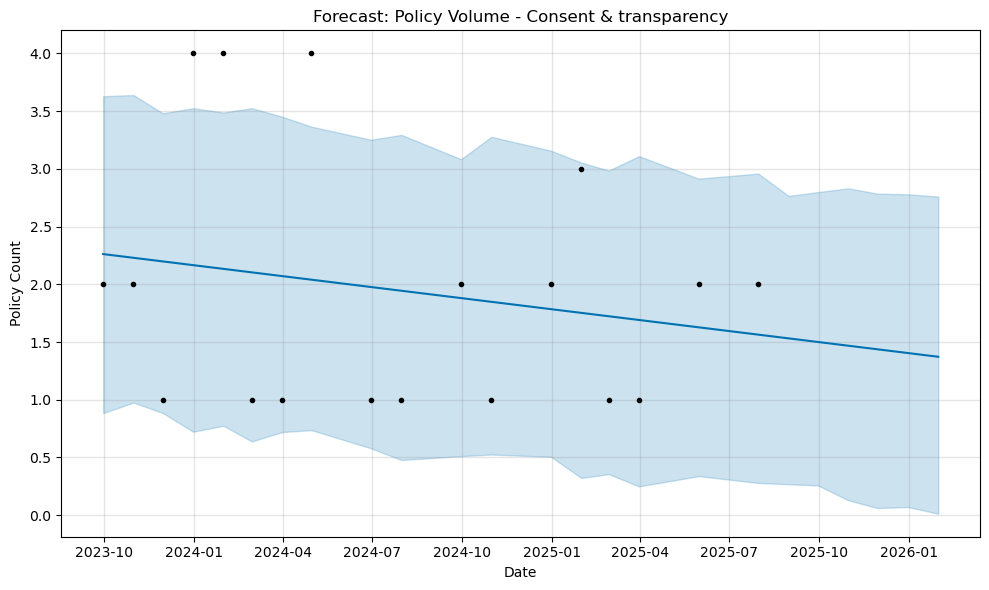

In [13]:
# Plot
model.plot(forecast)
plt.title(f"Forecast: Policy Volume - {topic_to_forecast}")
plt.xlabel("Date")
plt.ylabel("Policy Count")
plt.tight_layout()
plt.show()

### Forecast All Topics Combined (Monthly)

21:39:17 - cmdstanpy - INFO - Chain [1] start processing
21:39:17 - cmdstanpy - INFO - Chain [1] done processing


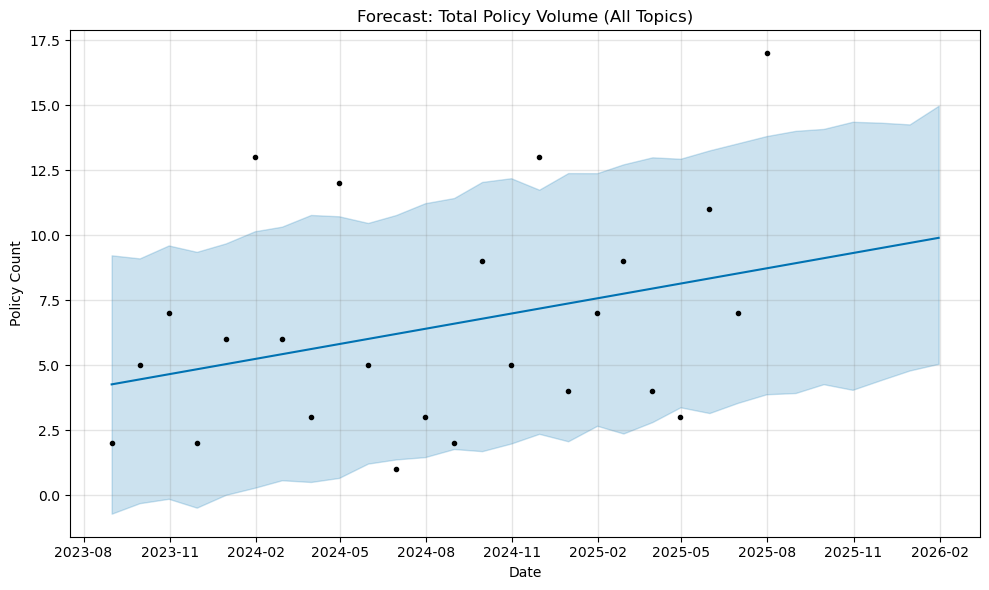

In [15]:
df_all = (
    df.groupby(pd.Grouper(key="date", freq="M"))
    .agg(policy_count=("title", "count"))
    .reset_index()
    .rename(columns={"date": "ds", "policy_count": "y"})
)

model = Prophet()
model.fit(df_all)

future = model.make_future_dataframe(periods=6, freq="M")
forecast = model.predict(future)

model.plot(forecast)
plt.title("Forecast: Total Policy Volume (All Topics)")
plt.xlabel("Date")
plt.ylabel("Policy Count")
plt.tight_layout()
plt.show()


## Aggregate Policies Quarterly by Topic

In [16]:
# Step 1: Load and Preprocess Data

df = pd.read_csv("../data/processed/cleaned_with_topic_and_severity.csv", parse_dates=["date"])

# Severity to numeric
severity_map = {"LOW": 1, "MEDIUM": 2, "HIGH": 3}
df["severity_score"] = df["severity"].str.upper().map(severity_map)

# Drop missing
df.dropna(subset=["date", "topic", "severity_score"], inplace=True)


# Quarterly Aggregation by Topic

quarterly_trends = (
    df.groupby([pd.Grouper(key="date", freq="Q"), "topic"])
    .agg(
        policy_count=("title", "count"),
        avg_severity=("severity_score", "mean")
    )
    .reset_index()
)

# Check available topics with > 1 quarter of data
print("\nTopics with at least 2 quarters of data:")
print(quarterly_trends["topic"].value_counts()[lambda x: x > 1])





Topics with at least 2 quarters of data:
topic
Consent & transparency             9
Fines & penalties                  9
International cooperation          8
Surveillance & tracking            4
Data breach & incident response    3
GDPR enforcement                   3
Biometric data                     3
AI & automated decision-making     3
Cross-border transfers             2
Name: count, dtype: int64


### Forecast for Selected Topic (Quarterly)

22:05:55 - cmdstanpy - INFO - Chain [1] start processing
22:05:55 - cmdstanpy - INFO - Chain [1] done processing


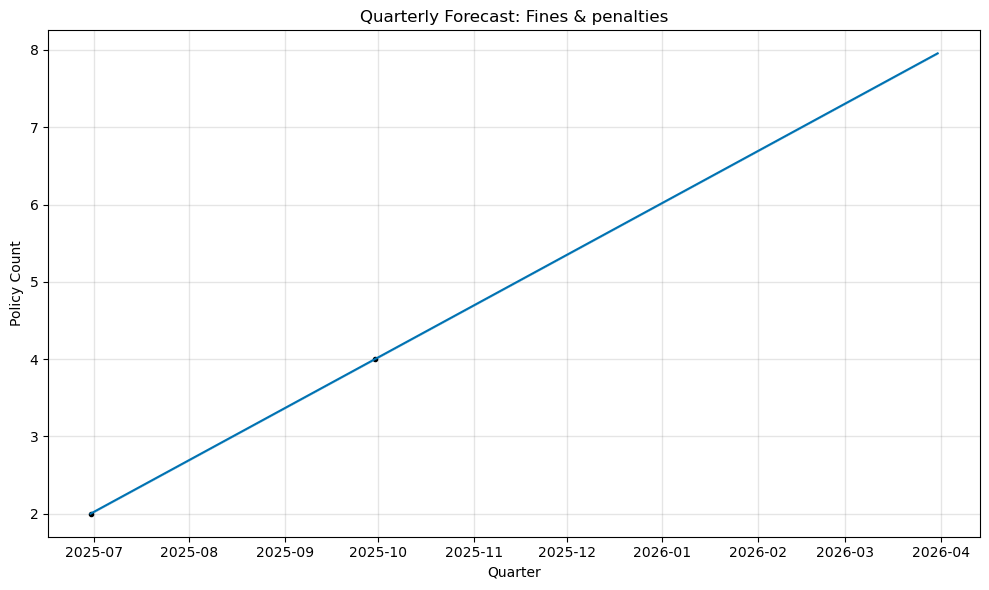

In [44]:
# Step 3: Select Topic and Prepare for Forecast

topic_to_forecast = "Fines & penalties"  # Replace as needed

df_topic = quarterly_trends[quarterly_trends["topic"] == topic_to_forecast][["date", "policy_count"]]
df_topic.rename(columns={"date": "ds", "policy_count": "y"}, inplace=True)


# step 4: Fit Prophet and Forecast

model = Prophet()
model.fit(df_topic)

# Forecast next 2 quarters
future = model.make_future_dataframe(periods=2, freq="Q")
forecast = model.predict(future)


# step 5: Plot the Forecast

model.plot(forecast)
plt.title(f"Quarterly Forecast: {topic_to_forecast}")
plt.xlabel("Quarter")
plt.ylabel("Policy Count")
plt.tight_layout()
plt.show()


### Forecast All Topics Combined (Quarterly)

22:06:48 - cmdstanpy - INFO - Chain [1] start processing


          ds   y
0 2023-09-30   8
1 2023-12-31  17
2 2024-03-31  23
3 2024-06-30  18
4 2024-09-30  14
5 2024-12-31  22
6 2025-03-31  20
7 2025-06-30  21
8 2025-09-30  17


22:06:48 - cmdstanpy - INFO - Chain [1] done processing


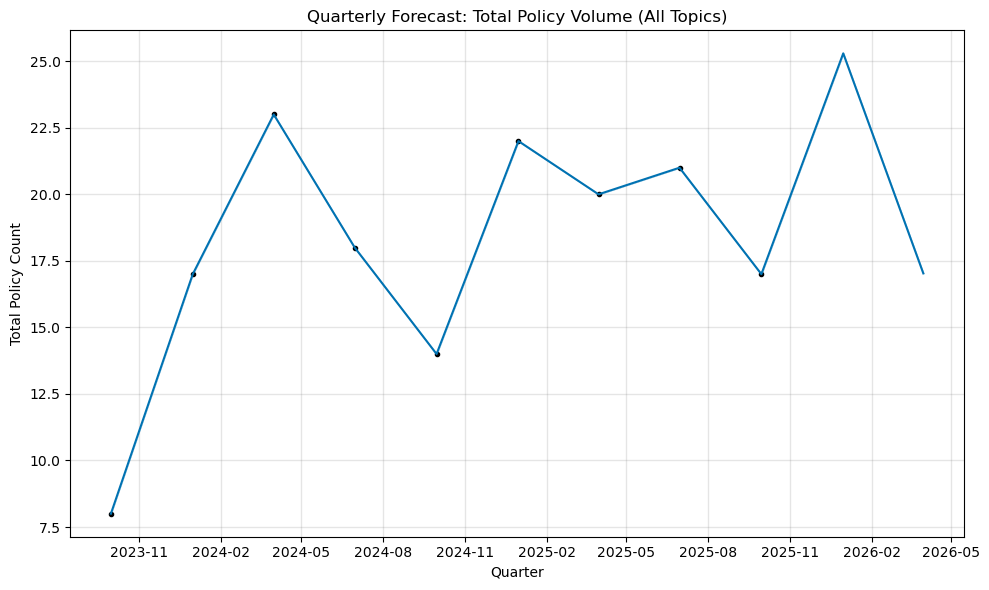

In [45]:
# Step 1: Load and Preprocess Data

df = pd.read_csv("../data/processed/cleaned_with_topic_and_severity.csv", parse_dates=["date"])

# Drop rows with missing date or title
df.dropna(subset=["date", "title"], inplace=True)

# Step 2: Aggregate Policy Counts Quarterly (All Topics)
quarterly_total = (
    df.groupby(pd.Grouper(key="date", freq="Q"))
    .agg(policy_count=("title", "count"))
    .reset_index()
    .rename(columns={"date": "ds", "policy_count": "y"})
)

print(quarterly_total)


# Step 3: Forecast with Prophet

model = Prophet()
model.fit(quarterly_total)

# Forecast next 2 quarters
future = model.make_future_dataframe(periods=2, freq="Q")
forecast = model.predict(future)


# Step 4: Plot Forecast

model.plot(forecast)
plt.title("Quarterly Forecast: Total Policy Volume (All Topics)")
plt.xlabel("Quarter")
plt.ylabel("Total Policy Count")
plt.tight_layout()
plt.show()


## Aggregate Policies Weekly by Topic

In [48]:
# Load file with severity and topic labels
df = pd.read_csv("../data/processed/cleaned_with_topic_and_severity.csv", parse_dates=["date"])

# Clean + map severity if not already done
severity_map = {"LOW": 1, "MEDIUM": 2, "HIGH": 3}
df["severity_score"] = df["severity"].str.upper().map(severity_map)
df.dropna(subset=["date", "topic"], inplace=True)


### Forecast for Selected Topic (Weekly)

22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing


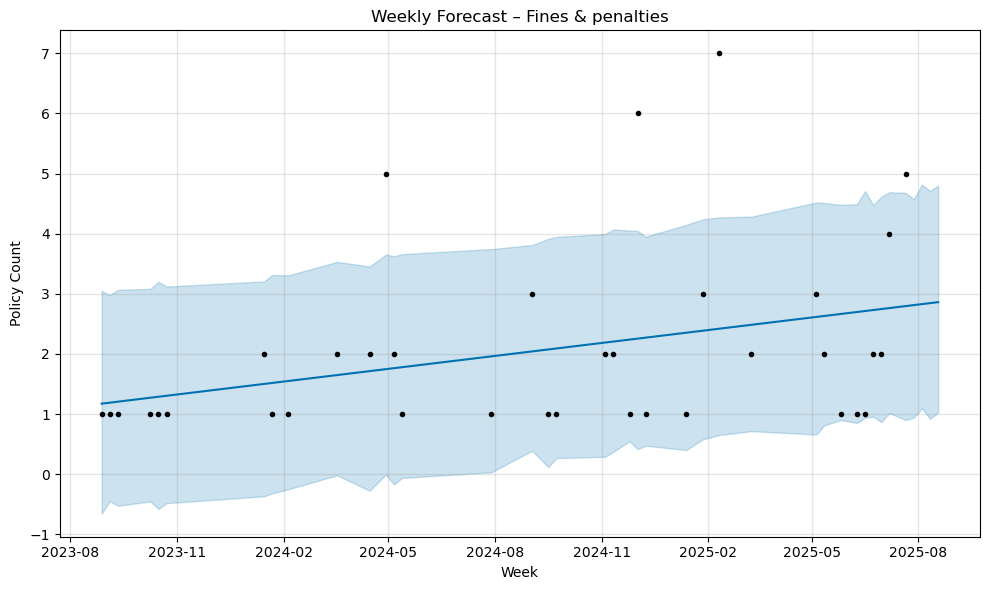

In [49]:
# Weekly aggregation by topic
weekly_by_topic = (
    df.groupby([pd.Grouper(key="date", freq="W-MON"), "topic"])
    .agg(policy_count=("title", "count"))
    .reset_index()
)

# Filter for topic
topic_to_forecast = "Fines & penalties"
df_topic = weekly_by_topic[weekly_by_topic["topic"] == topic_to_forecast][["date", "policy_count"]]
df_topic.rename(columns={"date": "ds", "policy_count": "y"}, inplace=True)

# Prophet Forecast
model = Prophet()
model.fit(df_topic)

future = model.make_future_dataframe(periods=4, freq="W-MON")
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title(f"Weekly Forecast – {topic_to_forecast}")
plt.xlabel("Week")
plt.ylabel("Policy Count")
plt.tight_layout()
plt.show()


### Forecast All Topics Combined (Weekly)

22:11:22 - cmdstanpy - INFO - Chain [1] start processing
22:11:23 - cmdstanpy - INFO - Chain [1] done processing


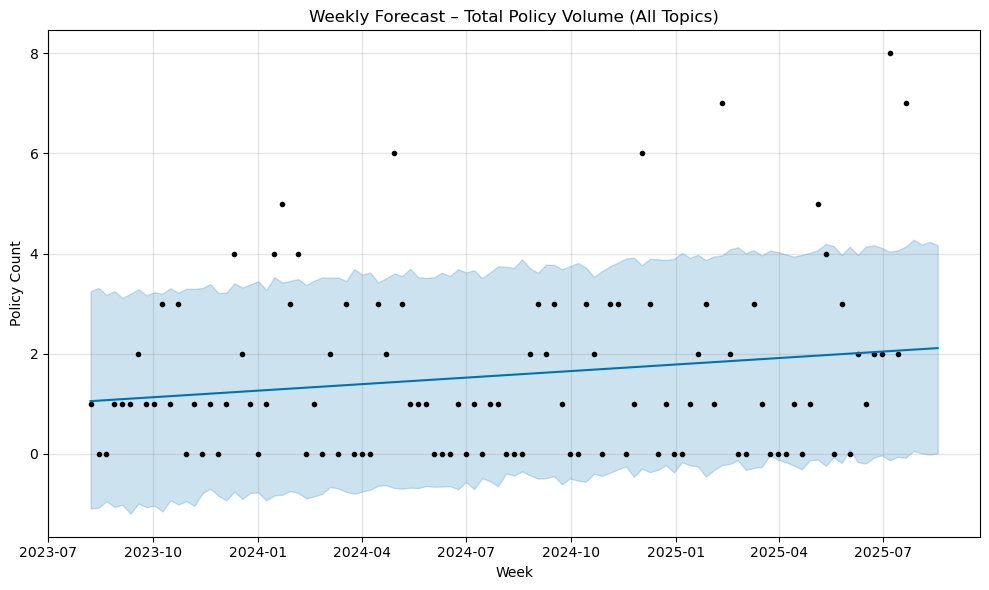

In [50]:
# Weekly aggregation (all topics)
weekly_total = (
    df.groupby(pd.Grouper(key="date", freq="W-MON"))  # W-MON means “weekly on Mondays” 
    .agg(policy_count=("title", "count"))
    .reset_index()
    .rename(columns={"date": "ds", "policy_count": "y"})
)

# Prophet Forecast
model_total = Prophet()
model_total.fit(weekly_total)

future_total = model_total.make_future_dataframe(periods=4, freq="W-MON")
forecast_total = model_total.predict(future_total)

# Plot
model_total.plot(forecast_total)
plt.title("Weekly Forecast – Total Policy Volume (All Topics)")
plt.xlabel("Week")
plt.ylabel("Policy Count")
plt.tight_layout()
plt.show()
